Kvasir V2 dataset trained on all classes with resnet50 without augmentation.  
- Fine tuning by unfreezing some layers (get aprox 80% accuracy)

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

## Training

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/kvasir-dataset-v2/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "MODEL": 'resnet50',
    "DS_INFO": 'complete',
    "resample": False,
    "neg_class": ['polyp'],
    "NUM_EPOCHS": 30,
    "BATCH_SIZE": 64,
    "IMG_SIZE": (32, 32, 3),
    "outcast": None,
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["NUM_EPOCHS"], config["BATCH_SIZE"], 
                                     config["IMG_SIZE"][1], config["DS_INFO"], config["MODEL"])

learning_rate = 0.01
fine_tune_at = 130
fine_tune_epochs = 15

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

Directories:  ['esophagitis' 'normal-pylorus' 'ulcerative-colitis' 'normal-cecum'
 'normal-z-line' 'polyps' 'dyed-resection-margins' 'dyed-lifted-polyps']

esophagitis       : 1000
normal-pylorus    : 1000
ulcerative-colitis: 1000
normal-cecum      : 1000
normal-z-line     : 1000
polyps            : 1000
dyed-resection-margins: 1000
dyed-lifted-polyps: 1000

Total number of images: 8000, in 8 classes
Dataset.list_files:  /mnt/sdb/kvasir-dataset-v2/*/*.*g 

[0 4 0 7 3 5 4 2 0 6]
[3 3 6 1 5 0 0 1 7 5]
[6 2 7 3 7 0 5 6 5 2]
[5 4 7 0 1 1 4 5 4 2]
[2 0 5 3 1 5 5 7 5 5]
[2 3 2 0 1 4 5 7 4 0]
[7 1 0 4 6 5 2 2 7 0]
[2 2 1 1 6 3 5 5 2 2]
[6 7 5 1 6 1 7 1 3 1]
[6 0 2 4 5 1 0 5 5 2]

Full dataset sample size:         8000
Train dataset sample size:        5600
Test dataset sample size:         1200
Validation dataset sample size:   1200


### Resnet50 transfer learning
see: https://adventuresinmachinelearning.com/transfer-learning-tensorflow-2/  
fine-tuning: https://www.tensorflow.org/tutorials/images/transfer_learning

In [4]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.keras import layers

Create and compile the model

In [5]:
res_net = tf.keras.applications.ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=config["IMG_SIZE"]
)

In [6]:
res_net.trainable = True

global_average_layer = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(params["NUM_CLASSES"], activation='softmax')

resnet50_model = tf.keras.Sequential([
        res_net,
        global_average_layer,
        output_layer])

In [7]:
if config["verbosity"] > 0:
    resnet50_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 16392     
Total params: 23,604,104
Trainable params: 23,550,984
Non-trainable params: 53,120
_________________________________________________________________


In [8]:
# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

resnet50_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir='./logs/resnet50_model', update_freq='batch')
callbacks = [tensorboard_cb]

Train the model

In [9]:
history = resnet50_model.fit(
    train_ds,
    steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
    epochs = config["NUM_EPOCHS"],
    validation_data = test_ds,
    validation_steps = params["test_size"] // config["BATCH_SIZE"],
    validation_freq = 1,
    callbacks = callbacks
)

Train for 87 steps, validate for 18 steps
Epoch 1/30
87/87 [==============================] - 11s 127ms/step - loss: 1.4743 - accuracy: 0.5724 - val_loss: 4.4144 - val_accuracy: 0.1189
Epoch 2/30
87/87 [==============================] - 3s 40ms/step - loss: 0.9248 - accuracy: 0.6746 - val_loss: 3.7082 - val_accuracy: 0.1224
Epoch 3/30
87/87 [==============================] - 4s 40ms/step - loss: 0.9638 - accuracy: 0.6611 - val_loss: 3.0450 - val_accuracy: 0.1285
Epoch 4/30
87/87 [==============================] - 4s 41ms/step - loss: 0.7313 - accuracy: 0.7024 - val_loss: 3.2337 - val_accuracy: 0.1293
Epoch 5/30
87/87 [==============================] - 4s 41ms/step - loss: 0.7045 - accuracy: 0.7195 - val_loss: 3.6986 - val_accuracy: 0.1285
Epoch 6/30
87/87 [==============================] - 4s 41ms/step - loss: 0.6895 - accuracy: 0.7073 - val_loss: 6.2836 - val_accuracy: 0.1259
Epoch 7/30
87/87 [==============================] - 4s 41ms/step - loss: 0.7584 - accuracy: 0.7281 - val_loss:

`Keras`
Save/load the model

In [10]:
# resnet50_model.save('models/{}.h5'.format(model_name))
# resnet50_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [11]:
resnet50_evaluate = resnet50_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["BATCH_SIZE"])

18/18 - 0s - loss: 0.6838 - accuracy: 0.7986


In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config["NUM_EPOCHS"])

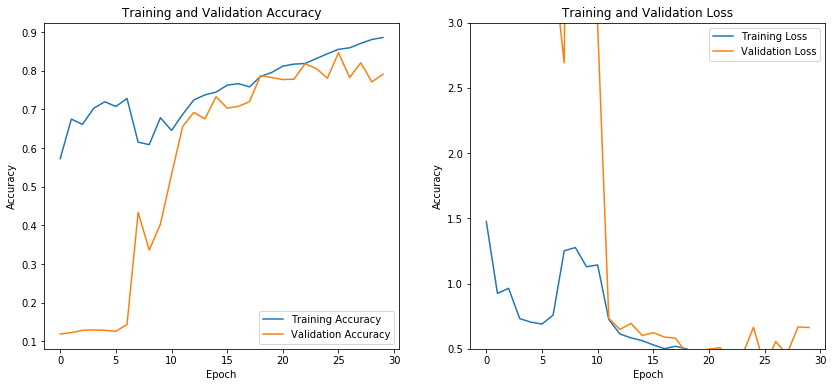

In [13]:
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0.5, 3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

### Fine tune the model

In [14]:
res_net.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(res_net.layers))

# Fine-tune from this layer onwards
fine_tune_at = fine_tune_at

# Freeze all the layers before the `fine_tune_at` layer
for layer in res_net.layers[:fine_tune_at]:
    layer.trainable = False

print("Number of layers unfreezed: ", len(resnet50_model.trainable_variables))

Number of layers in the base model:  175
Number of layers unfreezed:  56


In [15]:
# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate/10)
opt = tf.keras.optimizers.SGD(learning_rate=learning_rate/10, momentum=0.9)

resnet50_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
fine_tune_epochs = fine_tune_epochs
total_epochs = config["NUM_EPOCHS"] + fine_tune_epochs

history_fine = resnet50_model.fit(
    train_ds,
    steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
    epochs = total_epochs,
    initial_epoch = history.epoch[-1],
    validation_data = test_ds,
    validation_steps = params["test_size"] // config["BATCH_SIZE"],
    validation_freq = 1,
    callbacks = callbacks
)

Train for 87 steps, validate for 18 steps
Epoch 30/45
87/87 [==============================] - 7s 82ms/step - loss: 0.3049 - accuracy: 0.8852 - val_loss: 6.0655 - val_accuracy: 0.7057
Epoch 31/45
87/87 [==============================] - 3s 30ms/step - loss: 0.2475 - accuracy: 0.9061 - val_loss: 1.7257 - val_accuracy: 0.7665
Epoch 32/45
87/87 [==============================] - 3s 30ms/step - loss: 0.2525 - accuracy: 0.9089 - val_loss: 36.8679 - val_accuracy: 0.6189
Epoch 33/45
87/87 [==============================] - 3s 31ms/step - loss: 0.2450 - accuracy: 0.9045 - val_loss: 1.8315 - val_accuracy: 0.7847
Epoch 34/45
87/87 [==============================] - 3s 31ms/step - loss: 0.2207 - accuracy: 0.9210 - val_loss: 0.7974 - val_accuracy: 0.8203
Epoch 35/45
87/87 [==============================] - 3s 31ms/step - loss: 0.2142 - accuracy: 0.9192 - val_loss: 0.7181 - val_accuracy: 0.8411
Epoch 36/45
87/87 [==============================] - 3s 31ms/step - loss: 0.1962 - accuracy: 0.9208 - val

In [17]:
# For fine-tuning
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

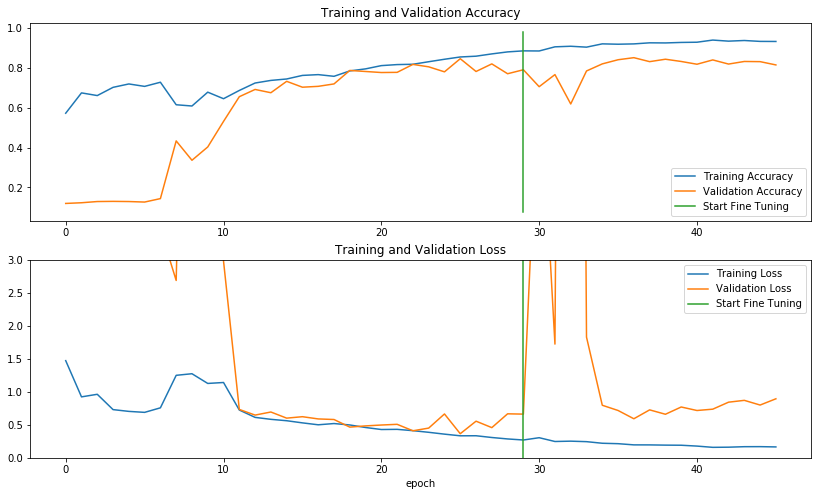

In [18]:
# Subplot 1
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([config["NUM_EPOCHS"]-1,config["NUM_EPOCHS"]-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([config["NUM_EPOCHS"]-1,config["NUM_EPOCHS"]-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

`Tensorboard`

## Predict new samples

In [19]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0000 esophagitis
0.0000 normal-pylorus
0.0000 ulcerative-colitis
1.0000 normal-cecum
0.0000 normal-z-line
0.0000 polyps
0.0000 dyed-resection-margins
0.0000 dyed-lifted-polyps

Label: normal-cecum
Predicton: normal-cecum


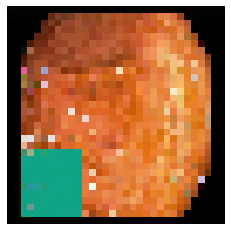

In [20]:
# Get a random image and label
rand = np.random.randint(0, config["BATCH_SIZE"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = resnet50_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,params["class_names"][i]))

print ("\nLabel:", params["class_names"][label])
print ("Predicton:", params["class_names"][np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [21]:
# Predict one batch
predictions = resnet50_model.predict(images)

print ('{:3}  {:<25} {:25}'.format('idx', 'label', 'pred'))
print ('---  {} {}'.format(25*'-', 25*'-'), end='')

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]]
    prediction = params["class_names"][np.argmax(pred)]
    print ('\n{:3}  {:25} {:25}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label                     pred                     
---  ------------------------- -------------------------
  0  normal-cecum              normal-cecum             
  1  dyed-lifted-polyps        dyed-lifted-polyps       
  2  esophagitis               esophagitis              
  3  dyed-lifted-polyps        dyed-lifted-polyps       
  4  polyps                    polyps                   
  5  dyed-lifted-polyps        dyed-lifted-polyps       
  6  polyps                    polyps                   
  7  dyed-lifted-polyps        dyed-lifted-polyps       
  8  polyps                    polyps                   
  9  dyed-lifted-polyps        dyed-lifted-polyps       
 10  dyed-lifted-polyps        dyed-lifted-polyps       
 11  polyps                    normal-cecum               Wrong
 12  ulcerative-colitis        ulcerative-colitis       
 13  dyed-lifted-polyps        dyed-lifted-polyps       
 14  dyed-lifted-polyps        dyed-lifted-polyps       
 15  ulcerative-colitis 